# Example paralellisation dask.delayed

In [1]:
# general python
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import numpy as np
import os
from pathlib import Path
import yaml
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import scipy
import xarray as xr
from tqdm import tqdm
import glob
from devtools import pprint
from tqdm import tqdm

In [2]:
import ewatercycle.models

In [3]:
# pip uninstall ewatercycle_parallelisation_sleep -y

In [4]:
# pip install git+https://github.com/Daafip/ewatercycle-test-parallelisation@main

In [5]:
from ewatercycle.models import ParallelisationSleep

In [6]:
model = ParallelisationSleep()

In [7]:
config, _ = model.setup(sleepiness=1)

In [8]:
model.initialize(config)

In [9]:
import time

In [10]:
%%time
model.update()

CPU times: user 0 ns, sys: 5.38 ms, total: 5.38 ms
Wall time: 1 s


## import DA function:

### Locally:

In [41]:
import importlib.util

def module_from_file(module_name, file_path):
    spec = importlib.util.spec_from_file_location(module_name, file_path)
    module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(module)
    return module

In [42]:
DA = module_from_file("DA",r'../eWaterCycle-DA/src/ewatercycle_DA/DA.py')

#### or from git:
```bash
pip install git+https://github.com/Daafip/eWaterCycle-DA@main
```

In [43]:
pip install git+https://github.com/Daafip/eWaterCycle-DA@main

In [44]:
from ewatercycle_DA import DA

### setup Ensemble

In [16]:
n_particles = 3

In [17]:
ensemble = DA.Ensemble(N=n_particles)
ensemble.setup()

In [18]:
setup_kwargs= {'sleepiness':1}

In [19]:
# this initializes the models for all ensemble members. 
ensemble.initialize(model_name="ParallelisationSleep",
                    forcing=None,
                    setup_kwargs=setup_kwargs) 

## Time current update step

In [20]:
%%time
ensemble.update(assimilate=False)

CPU times: user 8.26 ms, sys: 2.75 ms, total: 11 ms
Wall time: 3.01 s


In [21]:
%%time
for ensemble_member in ensemble.ensemble_list:
    ensemble_member.update()

CPU times: user 7.51 ms, sys: 1.09 ms, total: 8.59 ms
Wall time: 3.01 s


## using dask

In [62]:
import dask
from dask import delayed

In [23]:
@delayed
def update_member(ensemble, i):
    ensemble.ensemble_list[i].update()
    return ensemble.ensemble_list[i].get_value("sleep")

In [24]:
@delayed
def gather(*args):
    return list(args)

In [25]:
gathered = gather(*[update_member(ensemble,i) for i in range(ensemble.N)])

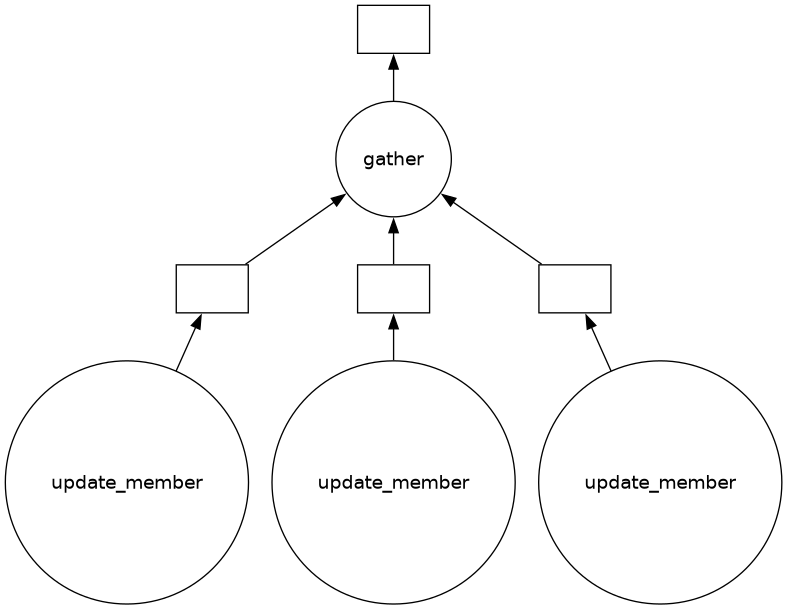

In [26]:
gathered.visualize()

In [27]:
%%time
gathered.compute()

CPU times: user 8.86 ms, sys: 9.63 ms, total: 18.5 ms
Wall time: 1.02 s


[array([1.]), array([1.]), array([1.])]

In [28]:
ensemble.finalize()

## repeat with more particles & longer time

In [48]:
n_particles = 30

In [49]:
ensemble = DA.Ensemble(N=n_particles)
ensemble.setup()

In [50]:
setup_kwargs= {'sleepiness':1}

In [51]:
%%time
# starting up this many docker containers also is a thing but yeah:
# this initializes the models for all ensemble members. 
ensemble.initialize(model_name="ParallelisationSleep",
                    forcing=None,
                    setup_kwargs=setup_kwargs) 

CPU times: user 516 ms, sys: 208 ms, total: 725 ms
Wall time: 41.7 s


## Time current update step

In [52]:
%%time
ensemble.update(assimilate=False)

CPU times: user 63.1 ms, sys: 103 ms, total: 166 ms
Wall time: 30.1 s


## using dask

In [53]:
gathered = gather(*[update_member(ensemble,i) for i in range(ensemble.N)])

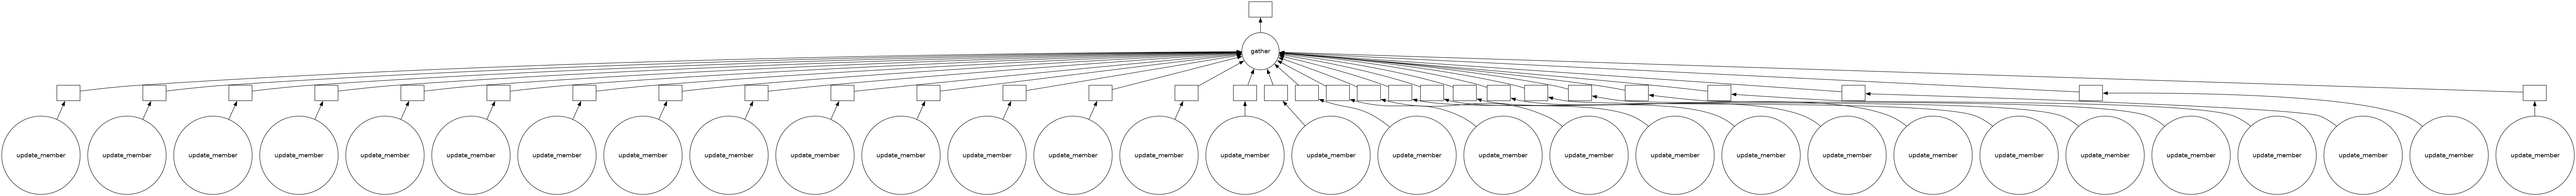

In [54]:
gathered.visualize()

In [55]:
%%time
_ = gathered.compute()

CPU times: user 48.8 ms, sys: 72.3 ms, total: 121 ms
Wall time: 3.05 s


### can also specify amount of workers:

In [56]:
import psutil
logical_n_psu = psutil.cpu_count(logical=True)
logical_n_psu

12

In [57]:
%%time
_ = gathered.compute(num_workers=logical_n_psu)

CPU times: user 50.8 ms, sys: 30.9 ms, total: 81.8 ms
Wall time: 3.03 s


In [58]:
%%time
_ = gathered.compute(num_workers= 2 * logical_n_psu)

CPU times: user 51 ms, sys: 27.6 ms, total: 78.6 ms
Wall time: 2.02 s


In [59]:
%%time
_ = gathered.compute(num_workers= 4 * logical_n_psu)

CPU times: user 44.8 ms, sys: 25.3 ms, total: 70.1 ms
Wall time: 1.02 s


or

In [63]:
%%time
with dask.config.set({"multiprocessing.context": "spawn", 'num_workers': 4 * logical_n_psu}):
    _ = gathered.compute()

CPU times: user 38.1 ms, sys: 12.8 ms, total: 50.9 ms
Wall time: 1.02 s


Exluding the initialization: x10 speed up

In [64]:
ensemble.finalize()